In [ ]:
micromamba activate scvelo_jupyter_new
micromamba run -n scvelo_jupyter_new pip install rds2py
micromamba run -n scvelo_jupyter_new pip install twine
micromamba run -n scvelo_jupyter_new pip install git+https://github.com/furlan-lab/pyviewmaster.git
micromamba run -n scvelo_jupyter_new pip install plotly==5.24.1
micromamba run -n scvelo_jupyter_new pip install colorcet

In [58]:
# Core scverse libraries
import scanpy as sc
import anndata as ad
import scvelo as scv
import os
import glob
import pandas as pd
import numpy as np
sc.settings.set_figure_params(dpi=100, facecolor="white")
import socket
from pyviewmaster import *
import seaborn as sns
import colorcet as cc
import plotly.express as px
import matplotlib.pyplot as plt

hostname = socket.gethostname()

if hostname.startswith("gizmo"):
  ROOT_DIR1 = "/fh/fast/furlan_s/datasets/AML/LOR_classifier/cds"
  ROOT_DIR2 = "/fh/fast/furlan_s/grp/data/ddata/BM_data"
else:
  ROOT_DIR1 = "/Users/sfurlan/Library/CloudStorage/OneDrive-SharedLibraries-FredHutchinsonCancerCenter/Furlan_Lab - General/datasets/AML/LOR_classifier/cds"
  ROOT_DIR2 = "/Users/sfurlan/Library/CloudStorage/OneDrive-SharedLibraries-FredHutchinsonCancerCenter/Furlan_Lab - General/experiments/patient_marrows/WC1/cds"


## LOAD SUMMARIZED EXPERIMENT OBJECT IN PYTHON

In [2]:
from rds2py import read_rds
ref =read_rds(ROOT_DIR1+"/240126_Combined_SE_Object.RDS")


In [3]:
coldata = get_coldata_rds_obj(ref)
coldata.set_index = coldata["rownames"]
rowdata = get_rowdata_rds_obj(ref)
rowdata.set_index = rowdata["gene_short_name"]
scounts = get_counts_rds_obj(ref)

In [4]:
rdata = ad.AnnData(scounts)
rdata.obs = coldata
rdata.var = rowdata
rdata.obs_names = coldata.index
rdata.var_names = rowdata.index
rdata.layers["counts"] = rdata.X.copy()

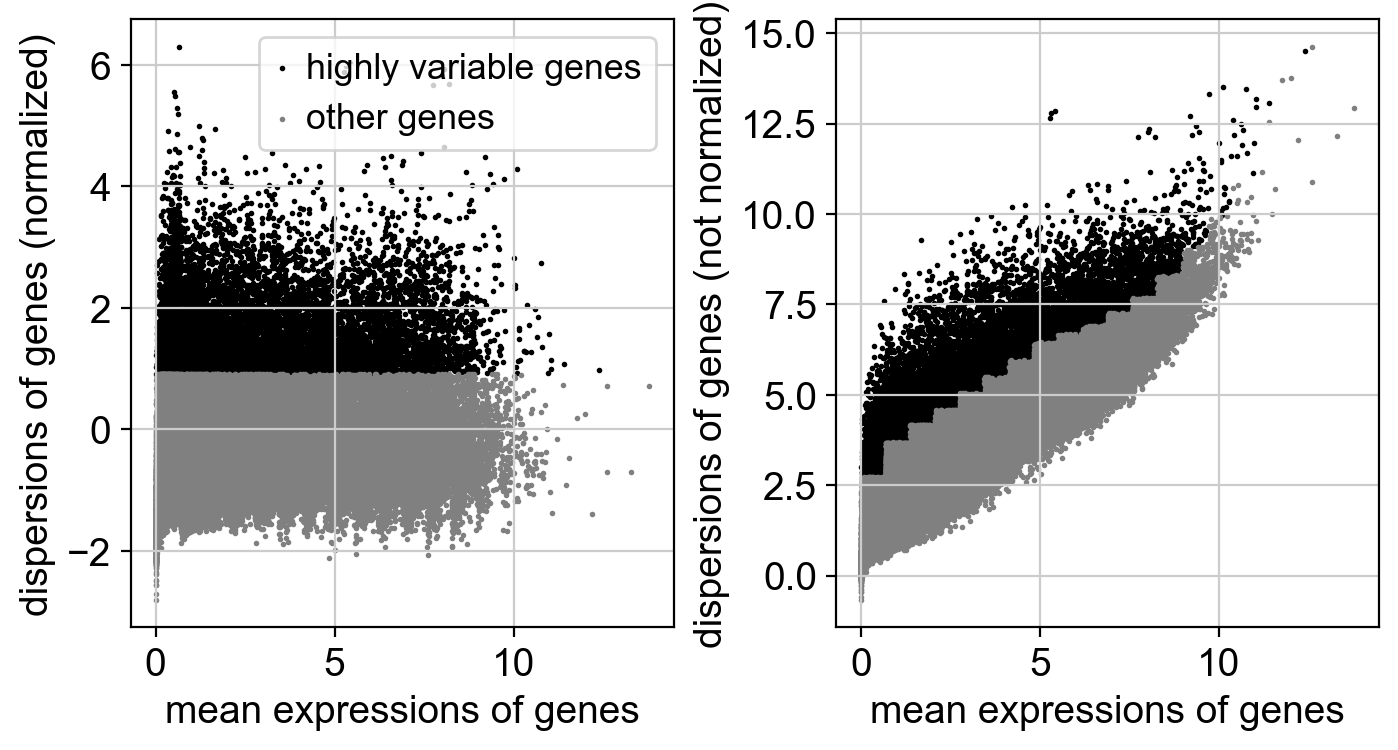

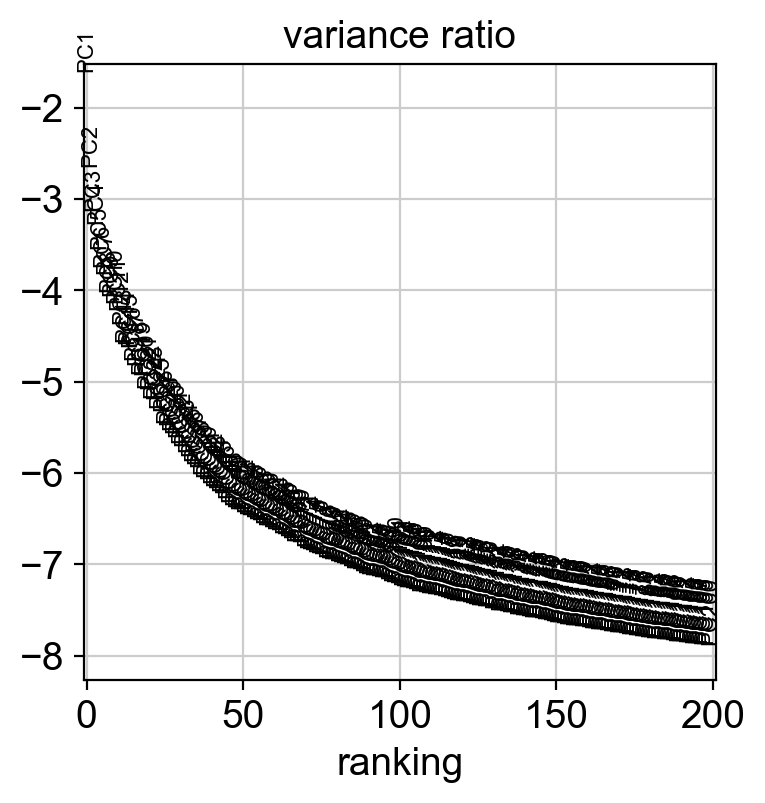

In [5]:
sc.pp.normalize_total(rdata)
sc.pp.log1p(rdata)
sc.pp.highly_variable_genes(rdata, n_top_genes=10000)
sc.pl.highly_variable_genes(rdata)
sc.tl.pca(rdata, n_comps=200)
sc.pl.pca_variance_ratio(rdata, n_pcs=200, log=True)


In [ ]:
sc.pp.neighbors(rdata, n_pcs=200)

sc.tl.umap(rdata, min_dist=0.4, n_components=3)

sc.pl.umap(rdata, color = "category1", projection = "3d")

In [9]:
palette = sns.color_palette(cc.glasbey, n_colors=50, as_cmap=True)

In [15]:
df = rdata.obsm['X_umap']
df = pd.DataFrame(df)
df.columns = ["umap1", "umap2", "umap3"]
df["category1"] = rdata.obs["category1"].values
df.index = rdata.obs.index
fig = px.scatter_3d(df, x='umap1', y='umap2', z='umap3',
              color='category1', color_discrete_sequence = palette)
fig.update_traces(marker_size = 1.5)
fig.show()


## LOAD QUERY

In [16]:
adata = sc.read_loom(ROOT_DIR2+"/WC_velocity.loom")

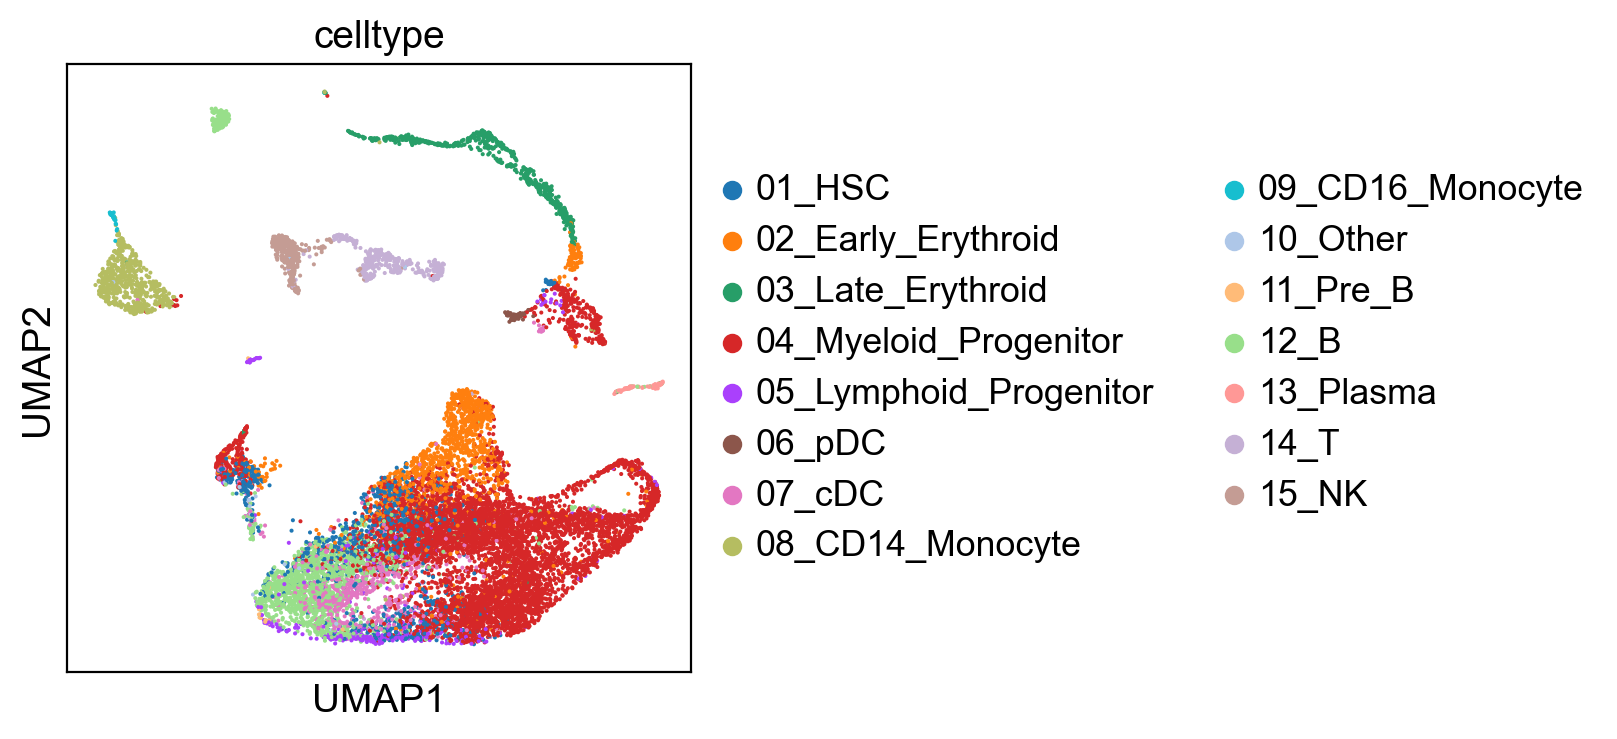

In [17]:
sc.pl.umap(adata, color = "celltype")


In [301]:
query = adata
ref = rdata
N=2
bulk_feature_row="gene_short_name"
bulk_assay_name="counts"
sc_assay_name="matrix"
dist="sc-direct"


In [325]:
import numpy as np
import pandas as pd

# Assume counts_query and sizes are already defined from earlier code
counts_query = get_counts_adata(query, layer=sc_assay_name)
sizes = sum_counts(counts_query, axis=1)
min_size = sizes.min()
max_size = sizes.max()

# Number of single cells to generate
ss_cells = N * query.shape[1]

if dist == "sc-model":
    print("Modeling count distribution of query using Empirical CDF")
    # Sort sizes to create the CDF
    sorted_sizes = np.sort(sizes)
    cdf = np.arange(1, len(sorted_sizes) + 1) / len(sorted_sizes)
    # Draw random samples from a uniform distribution
    uniform_samples = np.random.rand(ss_cells)
    # Use inverse transform sampling to get values that match the empirical CDF
    final_newsizes = np.interp(uniform_samples, cdf, sorted_sizes).astype(int)

else:
    # Use the direct sampling approach for "sc-direct" as before
    final_newsizes = np.random.choice(sizes, ss_cells, replace=True).astype(int)

print("Finding common features between ref and query")
genes_query = query.var_names
genes_ref = ref.var[bulk_feature_row].values
universe = np.intersect1d(genes_ref, genes_query)

if len(universe) == 0:
    raise ValueError("No common genes found between ref and query.")

print(f"Simulating {N} single cells for every bulk dataset case")

# Prepare the reference counts data
counts_ref_full = get_counts_adata(ref, layer="counts")
counts_ref_full = pd.DataFrame(counts_ref_full.todense().T)
counts_ref_full.index = genes_ref
counts_ref_full.columns = counts_ref_full.columns.astype(str)
counts_ref_full = counts_ref_full.loc[universe, :]
fdata = anndata.AnnData(counts_ref_full.T)
fdata.obs = ref.obs

Finding common features between ref and query
Simulating 2 single cells for every bulk dataset case


<Axes: ylabel='Count'>

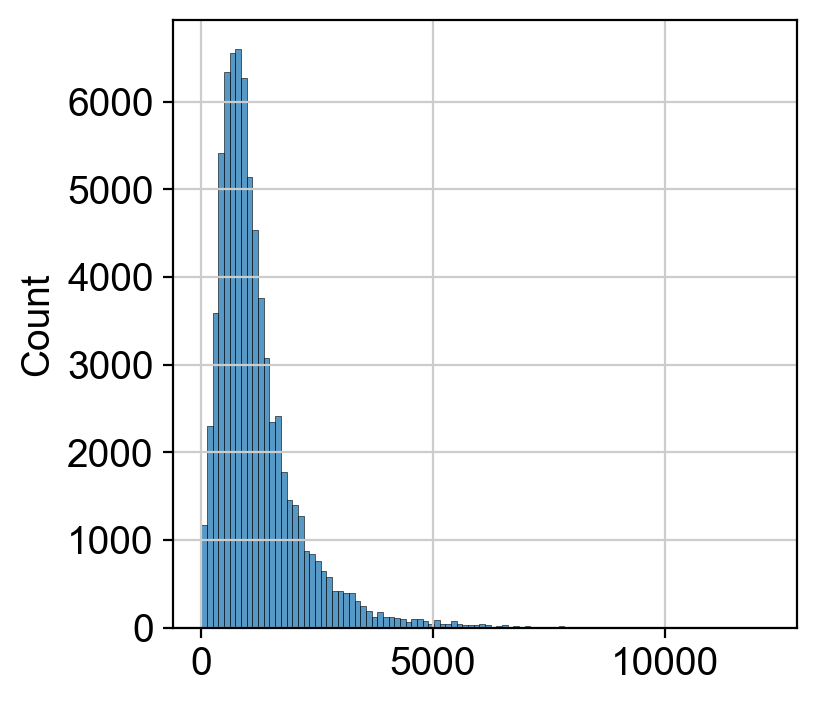

In [303]:
#sns.kdeplot(final_newsizes)
sns.histplot(final_newsizes, bins = 100)

<Axes: ylabel='Count'>

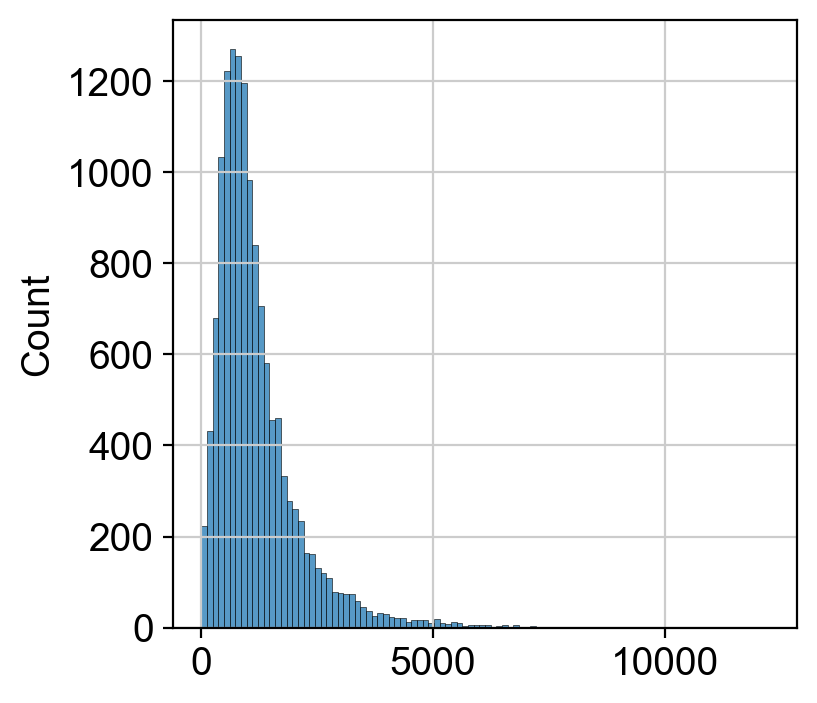

In [304]:
#sns.kdeplot(sizes)
sns.histplot(sizes, bins = 100)


In [305]:
import numpy as np
import pandas as pd

def downsample_counts_dataframe(df, count_column, n):
    """
    Downsamples a DataFrame with names as index and counts as values, preserving the original distribution.
    Ensures that all names in the original DataFrame appear in the output, with zero counts if not sampled.
    
    Parameters:
    df (pd.DataFrame): Input DataFrame with names as index and counts as values in one column.
    count_column (str): The name of the column containing the counts.
    n (int): The desired total number of downsampled items.
    
    Returns:
    pd.DataFrame: A new DataFrame with downsampled names and their counts, including zero counts if not sampled.
    """
    # Extract names and counts from the DataFrame
    counts = df[count_column].values
    names = df.index
    
    # Calculate proportions and downsampled counts
    total_count = counts.sum()
    proportions = counts / total_count
    downsampled_counts = (proportions * n).round().astype(int)

    # Adjust total count in one step to match exactly `n`
    diff = n - downsampled_counts.sum()
    if diff != 0:
        # Find indices of the elements with the largest fractional remainders
        fractional_remainders = (proportions * n) % 1
        adjustment_indices = np.argsort(fractional_remainders)[-abs(diff):]
        
        # Apply the adjustment based on `diff` sign
        downsampled_counts[adjustment_indices] += np.sign(diff)

    # Create a DataFrame with names and their downsampled counts
    downsampled_df = pd.DataFrame({count_column: downsampled_counts}, index=names)
    
    return downsampled_df


In [338]:
import pandas as pd
import numpy as np
import anndata as ad
from scipy import sparse

def downsample_counts_numpy(counts, n):
    """
    Downsamples a 1D array of counts to a specified total while preserving the original distribution.
    
    Parameters:
    counts (np.array): 1D array of counts for a single cell.
    n (int): The target total count for downsampling.
    
    Returns:
    np.array: Downsampled counts.
    """
    total_count = counts.sum()
    if total_count == 0:
        return counts  # If there are no counts, return as-is to avoid division by zero

    proportions = counts / total_count
    downsampled_counts = (proportions * n).round().astype(int)

    # Adjust to ensure the sum matches n exactly
    diff = n - downsampled_counts.sum()
    if diff != 0:
        fractional_remainders = (proportions * n) % 1
        adjustment_indices = np.argsort(fractional_remainders)[-abs(diff):]
        downsampled_counts[adjustment_indices] += np.sign(diff)

    return downsampled_counts

def expand_anndata(adata, fold=10):
    """
    Expands an AnnData object to `fold` times its size by downsampling the counts.
    
    Parameters:
    adata (AnnData): The input AnnData object.
    fold (int): The factor by which to expand the data.
    
    Returns:
    AnnData: A new AnnData object with the expanded data.
    """
    # Convert original counts to a dense matrix if sparse
    if sparse.issparse(adata.X):
        original_counts = adata.X.toarray()
    else:
        original_counts = adata.X

    # Initialize an array to hold expanded data
    expanded_data = np.zeros((original_counts.shape[0] * fold, original_counts.shape[1]), dtype=int)
    
    # Target total count per column (cell) per iteration
    target_counts = original_counts.sum(axis=0)

    # Perform downsampling for each iteration and store results in the expanded array
    for i in range(fold):
        for col_idx in range(original_counts.shape[1]):
            downsampled_counts = downsample_counts_numpy(original_counts[:, col_idx], target_counts[col_idx])
            expanded_data[i * original_counts.shape[0] : (i + 1) * original_counts.shape[0], col_idx] = downsampled_counts

    # Reshape the obs names to account for expansion
    expanded_obs_names = np.tile(adata.obs_names, fold)

    # Create a new AnnData object with the expanded counts
    expanded_adata = ad.AnnData(X=sparse.csr_matrix(expanded_data),
                                obs=pd.DataFrame(index=expanded_obs_names),
                                var=adata.var)
    
    return expanded_adata


In [340]:
fdataf = expand_anndata(fdata, fold= 10)

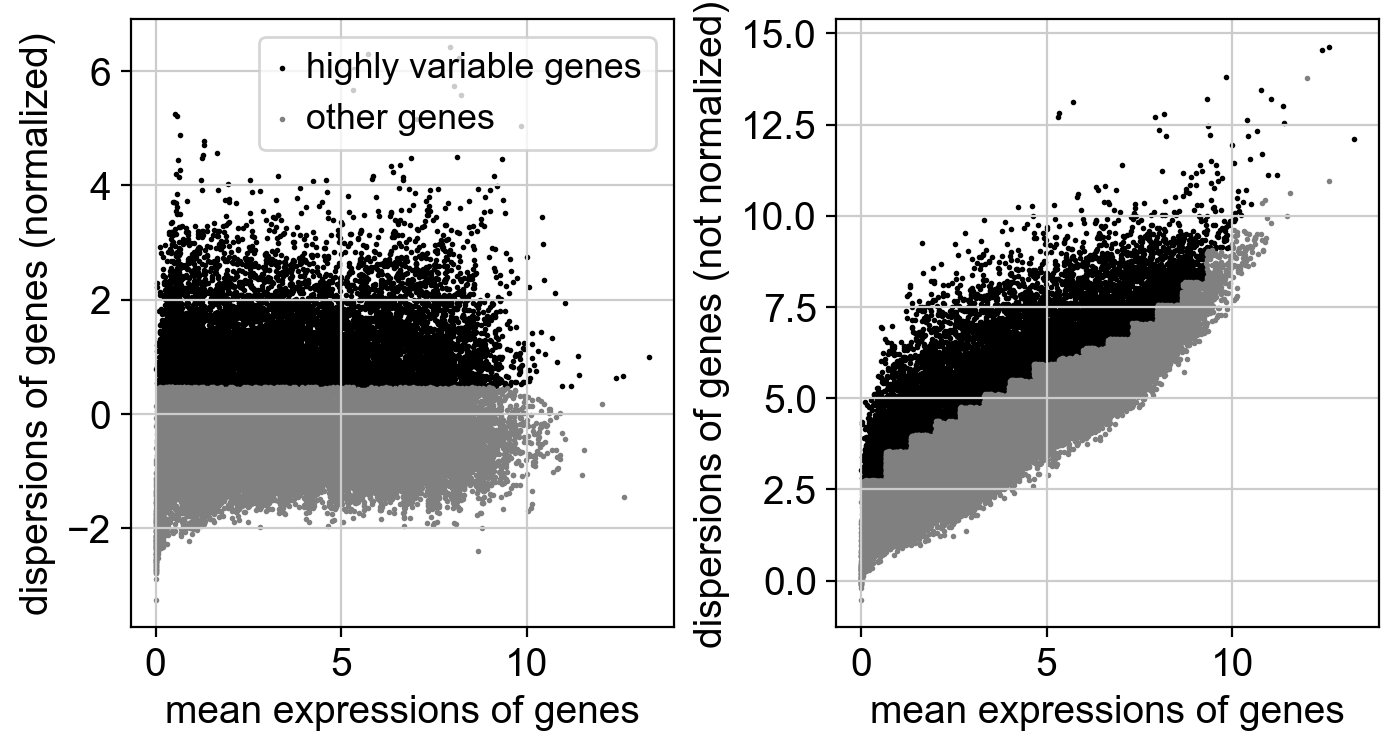

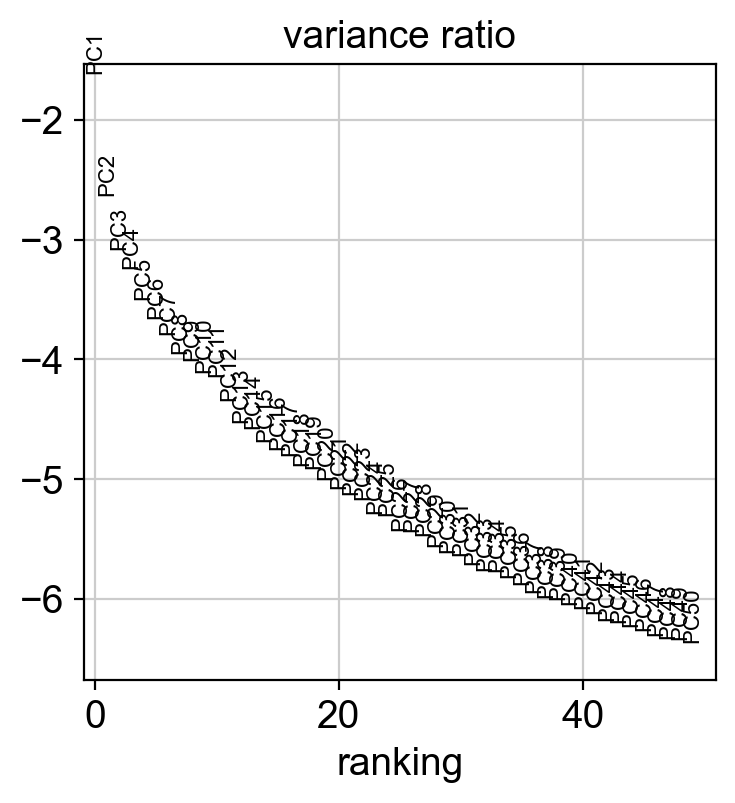

In [341]:
sc.pp.normalize_total(fdataf)
sc.pp.log1p(fdataf)
sc.pp.highly_variable_genes(fdataf, n_top_genes=10000)
sc.pl.highly_variable_genes(fdataf)
sc.tl.pca(fdataf, n_comps=50)
sc.pl.pca_variance_ratio(fdataf, n_pcs=50, log=True)

In [ ]:
sc.pp.neighbors(fdataf, n_pcs=50)

sc.tl.umap(fdataf, min_dist=0.4, n_components=3)

sc.pl.umap(fdataf, color = "category1", projection = "3d")